## **Problem Statement**

Implement SQL queries by MySQL on ErgastF1 database.

**Table List in ErgastF1 database**
<br>
circuits, constructorResults, constructors, constructorStandings, drivers, driverStandings, lapTimes, pitStops, qualifying, races, results, seasons, status, target
<br><br>
**Source**
https://relational.fit.cvut.cz/dataset/ErgastF1

### Relational Graph

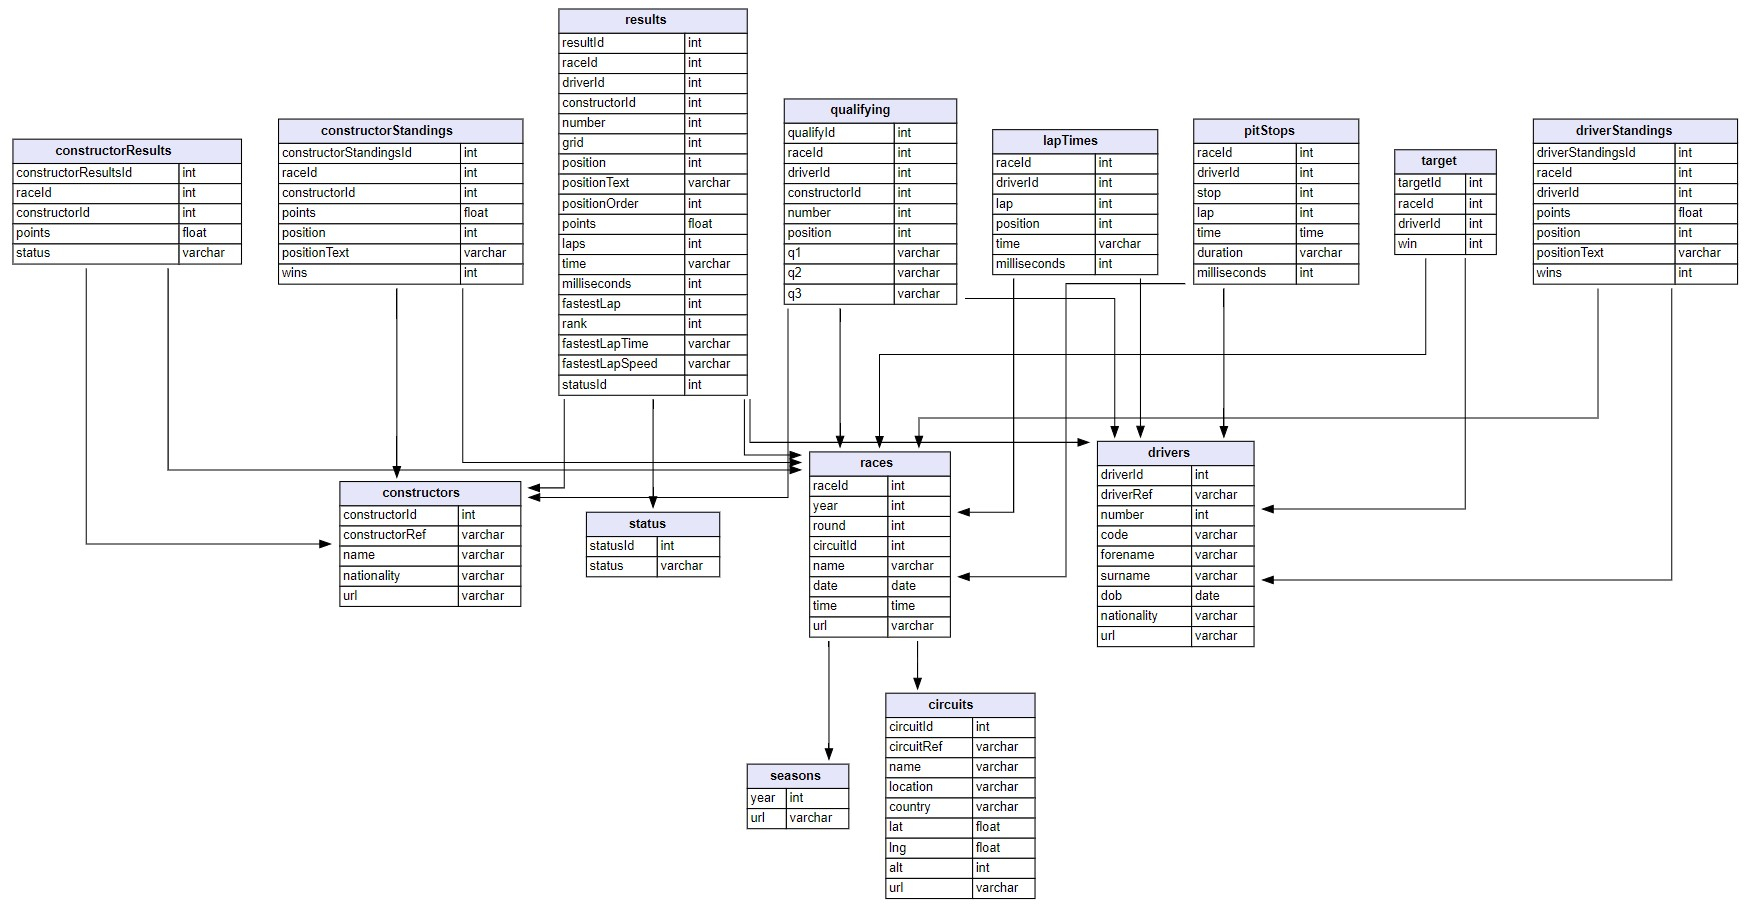

In [1]:
from IPython.display import Image
Image(filename='relation_graph.jpg')

### Set up query engine

In [2]:
from sqlalchemy import create_engine

def engine_gen():
    connection_string = 'mysql://{username}:{password}@{hostname}:{port}/{database}'

    engine = create_engine(
        connection_string.format(
            username='guest',
            password='relational',
            hostname='relational.fit.cvut.cz',
            port='3306',
            database='ErgastF1',
        )
    )
    return engine

engine = engine_gen()

### First query - The Most Aggresive Drivers
**What is aggresive drivers?**
<br>
A driver who is willing to take the risk of crashes to get more points.

In [3]:
import pandas as pd

def top_aggresive_drivers(query_engine=engine):
    query = '''
             WITH driver_points(driverId, all_points) AS(
                SELECT d.driverId, SUM(re.points)
                FROM drivers d
                INNER JOIN results re ON d.driverId=re.driverId
                WHERE re.points>0
                GROUP BY d.driverId
            ), driver_error(driverId, crash) AS(
                SELECT d.driverId, COUNT(re.statusId) as crash
                FROM drivers d
                INNER JOIN results re ON d.driverId=re.driverId
                WHERE statusId BETWEEN 3 and 4
                GROUP BY d.driverId
            ), driver_point_and_err(driverId, points, crash) AS (
                SELECT DISTINCT dp.driverId, dp.all_points as points, de.crash as crash
                FROM driver_points dp
                INNER JOIN driver_error de ON dp.driverId=de.driverId
            )
            SELECT d.driverId, d.forename as forename, d.surname as surname, 
                    SUM(points) as total_point, SUM(crash) as total_crash, sum(points)/sum(crash) as point_devided_by_crash
            FROM driver_point_and_err dpe
            INNER JOIN drivers d ON dpe.driverId=d.driverId
            GROUP BY d.driverId, d.forename , d.surname
            HAVING SUM(crash) > (SELECT AVG(crash) FROM driver_error) # AVG(crash) is 4.5
            ORDER BY sum(points)/sum(crash) DESC
            FETCH First 15 ROWS ONLY
            '''
    top_aggresive_drivers_df = pd.read_sql(query, query_engine)

    return top_aggresive_drivers_df

top_aggresive_drivers_df = top_aggresive_drivers(engine)
display(top_aggresive_drivers_df)

,driverId,forename,surname,total_point,total_crash,point_devided_by_crash
0,1,Lewis,Hamilton,2510.0,11.0,228.181818
1,20,Sebastian,Vettel,2343.0,11.0,213.000000
2,4,Fernando,Alonso,1842.0,11.0,167.454545
3,3,Nico,Rosberg,1594.5,13.0,122.653846
4,8,Kimi,Räikkönen,1498.0,18.0,83.222222
5,18,Jenson,Button,1235.0,15.0,82.333333
6,117,Alain,Prost,798.5,10.0,79.850000
7,30,Michael,Schumacher,1566.0,22.0,71.181818
8,13,Felipe,Massa,1155.0,19.0,60.789474
9,224,Emerson,Fittipaldi,281.0,5.0,56.200000


### Second query - The Most Disappointing Drivers
**What is disappointing drivers?**
<br>
A driver who gets a good position in qualifying but loses it in the race.

In [4]:
def top_disappointing_drivers(query_engine=engine):
    query = '''
            WITH avg_pitstops(raceId, driverId, duration_sec) AS(
                SELECT raceId, driverId, AVG(milliseconds)/1000 as duration_sec
                FROM pitStops ps
                GROUP BY raceId, driverId
            )
            SELECT d.driverId, d.forename, d.surname, 
                   AVG(q.position - re.position) as position_diff, COUNT(re.raceId) as race_num
            FROM drivers d
            INNER JOIN qualifying q ON d.driverId = q.driverId
            INNER JOIN results re ON re.raceId = q.raceId AND re.driverId = d.driverId
            INNER JOIN avg_pitstops aps ON aps.raceId = re.raceId AND aps.driverId = d.driverId
            WHERE aps.duration_sec < (SELECT AVG(duration_sec) FROM avg_pitstops)
            AND q.position is not NULL 
            AND re.position is not NULL
            GROUP BY d.driverId, d.forename, d.surname
            HAVING COUNT(re.raceId) > 10
            ORDER BY AVG(q.position - re.position) ASC
            FETCH FIRST 10 ROW ONLY
            '''
    top_disappointing_drivers_df = pd.read_sql(query, query_engine)

    return top_disappointing_drivers_df

def disappointing_records(query_engine=engine, driverId=1):
    query = '''
            WITH avg_pitstops(raceId, driverId, duration_sec) AS(
                SELECT raceId, driverId, AVG(milliseconds)/1000 as duration_sec
                FROM pitStops ps
                GROUP BY raceId, driverId
            )
            SELECT ra.year, ra.raceId as race_id, ra.name as Race_name, d.driverId, d.forename as Forename, d.surname as Surname, 
                   q.position as qualifying_position, re.position as result_position ,
                   q.position - re.position as position_diff
            FROM drivers d
            INNER JOIN qualifying q ON d.driverId = q.driverId
            INNER JOIN races ra ON q.raceId = ra.raceId
            INNER JOIN results re ON re.raceId = ra.raceId AND re.driverId = d.driverId
            INNER JOIN avg_pitstops aps ON aps.raceId = ra.raceId AND aps.driverId = d.driverId
            WHERE d.driverId={did}
            AND q.position is not NULL AND re.position is not NULL
            AND aps.duration_sec < (SELECT AVG(duration_sec) FROM avg_pitstops)
            ORDER BY q.position - re.position ASC
            FETCH FIRST 10 ROW ONLY
            '''.format(did=driverId)

    disappointing_records_df = pd.read_sql(query, query_engine)

    return disappointing_records_df

In [5]:
top_disappointing_drivers_df = top_disappointing_drivers(engine)
top_disappointing_drivers_df

,driverId,forename,surname,position_diff,race_num
0,3,Nico,Rosberg,-0.6471,102
1,17,Mark,Webber,-0.0588,51
2,1,Lewis,Hamilton,-0.0360,111
3,822,Valtteri,Bottas,0.0506,79
4,30,Michael,Schumacher,0.5769,26
5,807,Nico,Hülkenberg,0.5795,88
6,13,Felipe,Massa,0.6422,109
7,826,Daniil,Kvyat,0.6538,52
8,817,Daniel,Ricciardo,0.6961,102
9,20,Sebastian,Vettel,0.7257,113


In [6]:
disappointing_records_df = disappointing_records(engine,3)
display(disappointing_records_df)

,year,race_id,Race_name,driverId,Forename,Surname,qualifying_position,result_position,position_diff
0,2013,890,Hungarian Grand Prix,3,Nico,Rosberg,4,19,-15
1,2015,938,Italian Grand Prix,3,Nico,Rosberg,4,17,-13
2,2014,918,Abu Dhabi Grand Prix,3,Nico,Rosberg,1,14,-13
3,2013,883,Bahrain Grand Prix,3,Nico,Rosberg,1,9,-8
4,2015,936,Hungarian Grand Prix,3,Nico,Rosberg,2,8,-6
5,2013,884,Spanish Grand Prix,3,Nico,Rosberg,1,6,-5
6,2011,847,Canadian Grand Prix,3,Nico,Rosberg,6,11,-5
7,2016,953,Monaco Grand Prix,3,Nico,Rosberg,2,7,-5
8,2012,860,Australian Grand Prix,3,Nico,Rosberg,7,12,-5
9,2012,879,Brazilian Grand Prix,3,Nico,Rosberg,10,15,-5


### Third query - The Best Defender For Teammates
**What is Defender?**
<br>
A driver who blocks another driver for its leading teammate.

In [7]:
def top_defender_drivers(query_engine=engine):

    query = '''
            WITH driver_lap(raceId, lap, driverId, position) AS(
                SELECT raceId, lap, d.driverId, position
                FROM drivers d
                INNER JOIN lapTimes l ON d.driverId=l.driverId
                WHERE d.driverId < 300     # to decrease the execution  time
            ), cartesian_product_driver_lap(raceId, lap, driverId_1, position_1, driverId_2, position_2) AS(
                SELECT d1.raceId, d1.lap, d1.driverId, d1.position, d2.driverId, d2.position
                FROM driver_lap d1, driver_lap d2
                WHERE d1.raceId=d2.raceId
                AND d1.lap=d2.lap 
                AND d1.driverId<>d2.driverId
                AND d1.position < d2.position
            ), driver_and_teammate_lap(raceId, lap, driverId_1, position_1, driverId_2, position_2) AS(
                SELECT c.raceId, c.lap, c.driverId_1, c.position_1, c.driverId_2, c.position_2
                FROM cartesian_product_driver_lap c
                INNER JOIN results r1 ON c.raceId=r1.raceId AND c.driverId_1=r1.driverId
                INNER JOIN results r2 ON c.raceId=r2.raceId AND c.driverId_2=r2.driverId
                WHERE r1.constructorId=r2.constructorId
                # WHERE c.position_1 < c.position_2, already exist
            ), drivers_and_victim_and_advanced_teammate
                            (raceId, lap, defender_driverId, defender_position, 
                                          victim_driverId, victim_position, 
                                          teammate_driverId, teammate_position) AS(
                SELECT c1.raceId, c1.lap, 
                        c1.driverId_1, c1.position_1, 
                        c1.driverId_2, c1.position_2, 
                        d_with_teammate.driverId_1, d_with_teammate.position_1
                FROM cartesian_product_driver_lap c1
                INNER JOIN driver_and_teammate_lap d_with_teammate 
                        ON c1.raceId=d_with_teammate.raceId 
                           AND c1.lap=d_with_teammate.lap
                           AND c1.driverId_1 = d_with_teammate.driverId_2
                # now, there is three driver: teammate -> defender -> victim
            ), defender_records(raceId, startlap, defender_driverId, victim_driverId, teammate_driverId) AS(
                SELECT c1.raceId, c1.lap, c1.defender_driverId, c1.victim_driverId, c1.teammate_driverId
                FROM drivers_and_victim_and_advanced_teammate c1
                WHERE c1.victim_position-c1.defender_position BETWEEN 1 AND 2
                AND EXISTS(
                    SELECT *
                    FROM drivers_and_victim_and_advanced_teammate c2
                    WHERE c1.raceId=c2.raceId
                    AND c1.lap=c2.lap-1   # next lap
                    AND c1.defender_driverId=c2.defender_driverId
                    AND c1.victim_driverId=c2.victim_driverId
                    AND c2.victim_position-c2.defender_position BETWEEN 1 AND 2)
                AND EXISTS(
                    SELECT *
                    FROM drivers_and_victim_and_advanced_teammate c3
                    WHERE c1.raceId=c3.raceId
                    AND c1.lap=c3.lap-2
                    AND c1.defender_driverId=c3.defender_driverId
                    AND c1.victim_driverId=c3.victim_driverId
                    AND c3.victim_position-c3.defender_position BETWEEN 1 AND 2)
                AND EXISTS(
                    SELECT *
                    FROM drivers_and_victim_and_advanced_teammate c4
                    WHERE c1.raceId=c4.raceId
                    AND c1.lap=c4.lap-3
                    AND c1.defender_driverId=c4.defender_driverId
                    AND c1.victim_driverId=c4.victim_driverId
                    AND c4.victim_position-c4.defender_position BETWEEN 1 AND 2)
                AND EXISTS(
                    SELECT *
                    FROM drivers_and_victim_and_advanced_teammate c5
                    WHERE c1.raceId=c5.raceId
                    AND c1.lap=c5.lap-4
                    AND c1.defender_driverId=c5.defender_driverId
                    AND c1.victim_driverId=c5.victim_driverId
                    AND c5.victim_position-c5.defender_position BETWEEN 1 AND 2)
                ORDER BY c1.raceId, c1.lap, c1.defender_driverId, c1.victim_driverId ASC
            )
            SELECT defender_driverId, d.forename as defender_forename, d.surname as defender_surname, 
                    COUNT(startlap) as defend_point
            FROM defender_records dr
            INNER JOIN drivers d ON dr.defender_driverId=d.driverId
            GROUP BY defender_driverId, d.forename, d.surname
            ORDER BY COUNT(startlap) DESC
            FETCH FIRST 10 ROWS ONLY
            '''
    top_defender_drivers_df = pd.read_sql(query, query_engine)

    return top_defender_drivers_df

In [8]:
top_defender_drivers_df = top_defender_drivers()
display(top_defender_drivers_df)

,defender_driverId,defender_forename,defender_surname,defend_point
0,22,Rubens,Barrichello,7390
1,14,David,Coulthard,6338
2,13,Felipe,Massa,5723
3,18,Jenson,Button,5543
4,21,Giancarlo,Fisichella,4554
5,8,Kimi,Räikkönen,4268
6,15,Jarno,Trulli,4148
7,17,Mark,Webber,4041
8,23,Ralf,Schumacher,4014
9,2,Nick,Heidfeld,3962


In [9]:
def defender_best_records(defender_driverId, query_engine=engine):

    query = '''
            WITH driver_lap(raceId, lap, driverId, position) AS(
                SELECT raceId, lap, d.driverId, position
                FROM drivers d
                INNER JOIN lapTimes l ON d.driverId=l.driverId
                WHERE d.driverId < 300     # to decrease the execution  time
            ), cartesian_product_driver_lap(raceId, lap, driverId_1, position_1, driverId_2, position_2) AS(
                SELECT d1.raceId, d1.lap, d1.driverId, d1.position, d2.driverId, d2.position
                FROM driver_lap d1, driver_lap d2
                WHERE d1.raceId=d2.raceId
                AND d1.raceId=d2.raceId
                AND d1.lap=d2.lap 
                AND d1.driverId<>d2.driverId
                AND d1.position < d2.position
            ), driver_and_teammate_lap(raceId, lap, driverId_1, position_1, driverId_2, position_2) AS(
                SELECT c.raceId, c.lap, c.driverId_1, c.position_1, c.driverId_2, c.position_2
                FROM cartesian_product_driver_lap c
                INNER JOIN results r1 ON c.raceId=r1.raceId AND c.driverId_1=r1.driverId
                INNER JOIN results r2 ON c.raceId=r2.raceId AND c.driverId_2=r2.driverId
                WHERE r1.constructorId=r2.constructorId
                # WHERE c.position_1 < c.position_2, already exist
            ), drivers_and_victim_and_advanced_teammate
                            (raceId, lap, defender_driverId, defender_position, 
                                          victim_driverId, victim_position, 
                                          teammate_driverId, teammate_position) AS(
                SELECT c1.raceId, c1.lap, c1.driverId_1, c1.position_1, c1.driverId_2, c1.position_2, d_with_teammate.driverId_1, d_with_teammate.position_1
                FROM cartesian_product_driver_lap c1
                INNER JOIN driver_and_teammate_lap d_with_teammate 
                        ON c1.raceId=d_with_teammate.raceId 
                           AND c1.lap=d_with_teammate.lap
                           AND c1.driverId_1 = d_with_teammate.driverId_2
                WHERE c1.driverId_1={df_did}
            ), defend_record(raceId, start_lap, defender_driverId, defender_position,
                                                victim_driverId, victim_position,
                                                teammate_driverId, teammate_position) AS (
            SELECT c1.raceId, c1.lap as start_lap, c1.defender_driverId, c1.defender_position, 
                                                    c1.victim_driverId, c1.victim_position,
                                                     c1.teammate_driverId, c1.teammate_position
            FROM drivers_and_victim_and_advanced_teammate c1
            WHERE c1.victim_position-c1.defender_position BETWEEN 1 AND 2
            AND EXISTS(
                SELECT *
                FROM drivers_and_victim_and_advanced_teammate c2
                WHERE c1.raceId=c2.raceId
                AND c1.lap=c2.lap-1
                AND c1.defender_driverId=c2.defender_driverId
                AND c1.victim_driverId=c2.victim_driverId
                AND c2.victim_position-c2.defender_position BETWEEN 1 AND 2)
            AND EXISTS(
                SELECT *
                FROM drivers_and_victim_and_advanced_teammate c3
                WHERE c1.raceId=c3.raceId
                AND c1.lap=c3.lap-2
                AND c1.defender_driverId=c3.defender_driverId
                AND c1.victim_driverId=c3.victim_driverId
                AND c3.victim_position-c3.defender_position BETWEEN 1 AND 2)
            AND EXISTS(
                SELECT *
                FROM drivers_and_victim_and_advanced_teammate c4
                WHERE c1.raceId=c4.raceId
                AND c1.lap=c4.lap-3
                AND c1.defender_driverId=c4.defender_driverId
                AND c1.victim_driverId=c4.victim_driverId
                AND c4.victim_position-c4.defender_position BETWEEN 1 AND 2)
            AND EXISTS(
                SELECT *
                FROM drivers_and_victim_and_advanced_teammate c5
                WHERE c1.raceId=c5.raceId
                AND c1.lap=c5.lap-4
                AND c1.defender_driverId=c5.defender_driverId
                AND c1.victim_driverId=c5.victim_driverId
                AND c5.victim_position-c5.defender_position BETWEEN 1 AND 2)
            ORDER BY c1.raceId, c1.lap, c1.defender_driverId, c1.victim_driverId ASC
            )
            SELECT r.year, dr.raceId, r.name as race_name, dr.defender_driverId, def.forename as defender_forename, def.surname as defender_surname,
                                            dr.victim_driverId, vic.forename as victim_forename, vic.surname as victim_surname,
                                            # dr.teammate_driverId, tea.forename as teammate_forename, tea.surname as teammate_furname,
                                            COUNT(dr.start_lap) as defend_points
            FROM defend_record dr
            INNER JOIN races r ON r.raceId=dr.raceId 
            INNER JOIN drivers def ON def.driverId = dr.defender_driverId
            INNER JOIN drivers vic ON vic.driverId = dr.victim_driverId
            INNER JOIN drivers tea ON tea.driverId = dr.teammate_driverId
            GROUP BY r.year, dr.raceId, r.name, dr.defender_driverId, def.forename,def.surname,dr.victim_driverId,
                        vic.forename,vic.surname,dr.teammate_driverId, tea.forename,tea.surname
            ORDER BY COUNT(dr.start_lap) DESC
            FETCH FIRST 10 ROWS ONLY
            '''.format(df_did=defender_driverId)
    defender_best_records_df = pd.read_sql(query, query_engine)

    return defender_best_records_df

In [10]:
defender_best_records_df = defender_best_records(22)
display(defender_best_records_df)

,year,raceId,race_name,defender_driverId,defender_forename,defender_surname,victim_driverId,victim_forename,victim_surname,defend_points
0,2000,169,Hungarian Grand Prix,22,Rubens,Barrichello,49,Heinz-Harald,Frentzen,64
1,2009,6,Monaco Grand Prix,22,Rubens,Barrichello,8,Kimi,Räikkönen,62
2,2004,102,Hungarian Grand Prix,22,Rubens,Barrichello,4,Fernando,Alonso,60
3,2001,147,Monaco Grand Prix,22,Rubens,Barrichello,56,Eddie,Irvine,58
4,2001,153,Hungarian Grand Prix,22,Rubens,Barrichello,23,Ralf,Schumacher,58
5,2002,139,United States Grand Prix,22,Rubens,Barrichello,14,David,Coulthard,56
6,2005,83,Hungarian Grand Prix,22,Rubens,Barrichello,4,Fernando,Alonso,54
7,2006,55,Australian Grand Prix,22,Rubens,Barrichello,14,David,Coulthard,52
8,2004,102,Hungarian Grand Prix,22,Rubens,Barrichello,31,Juan,Pablo Montoya,51
9,2007,43,French Grand Prix,22,Rubens,Barrichello,17,Mark,Webber,51
